### Purpose of this agent is to call a right too for a right task from user query not universal answer any question

In [1]:
# paramter cell do not remove!!
# nb_parm='datalake|raw/pdf|Birddiversityanddistribution|pdf||300|150'
# nb_parm='datalake|raw/text-csv|PFW_spp_translation_table_May2024|csv||300|150'
nb_parm='llmnok'
question = 'how many bird species are in migratory?'
embed_model = "mxbai-embed-large" 
gen_model = "deepseek-r1:7b"
# collection = "Bridknowledge"

In [2]:
import sys
import os

sys.path.append("/home/jovyan/notebooks")
from Framework.module import Utility

## Do the task after this

## Register LLM and bind tools from pool of tools

In [3]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
import importlib
import inspect
from importlib import import_module
from langchain_core.tools import BaseTool
from email.message import EmailMessage
from typing import List
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
import smtplib
from Framework import base_tools

def load_all_tools(module_path: str):
    """
    Load all @tool-decorated functions from a module.

    Args:
        module_path (str): Python module path like 'tools'

    Returns:
        List of tool function objects
    """
    tools = []
    module = import_module(module_path)
    for name, obj in inspect.getmembers(module):
        if isinstance(obj, BaseTool):
            tools.append(obj)
    return tools
    
utility_tools = load_all_tools("Framework.pool_of_tools")

# qwen2.5:7b
# llama3-groq-tool-use:8b
llm = ChatOllama(
    model="qwen2.5:7b",
    temperature=0,
    base_url="http://host.docker.internal:11434",
    functions=utility_tools,      # pass the list of BaseTool
    function_call="auto"          # let the model decide when to call
)

llm_with_tools = llm.bind_tools(utility_tools)

utility_tools
 

USER_AGENT environment variable not set, consider setting it to identify your requests.


[StructuredTool(name='add', description='Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x7f81d2a34fe0>),
 StructuredTool(name='describe_table', description="Returns detailed schema information about a table (column, types, constraints).\n\nArgs:\n   reasoning: Detailed explanation of why you need to undestand this table's structure\n   table_name: Exact name of the table to describe (case-sensitive, no quotes needed)\n\nReturns:\n    String containing table schema information", args_schema=<class 'langchain_core.utils.pydantic.describe_table'>, func=<function describe_table at 0x7f81d2a35940>),
 StructuredTool(name='divide', description='Divide a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x7f81d2a35300>),
 StructuredTool(name='execute_sql', description='Execute SQL query a

## add retriever

In [4]:
from langchain_community.document_loaders import WebBaseLoader
import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings

embedding_model = OllamaEmbeddings(
    model="mxbai-embed-large",
    base_url="http://host.docker.internal:11434"
)

list_of_web_research = {
                        "https://clevertap.com/blog/rfm-analysis/?utm_source=chatgpt.com": ("blogInner__content"),
                        "https://www.techtarget.com/searchdatamanagement/definition/RFM-analysis?utm_source=chatgpt.com": ("content-columns"),
                        "https://www.mckinsey.com/capabilities/growth-marketing-and-sales/our-insights/the-value-of-getting-personalization-right-or-wrong-is-multiplying?utm_source=chatgpt.com": ("mck-o-container--outer"),
                        "https://www.optimove.com/resources/learning-center/rfm-segmentation?utm_source=chatgpt.com": ("single-article"),
                        "https://business.adobe.com/blog/basics/marketing-personalization?utm_source=chatgpt.com": ("content"),
                        "https://www.adquadrant.com/increasing-engagement-with-behavioral-transactional-and-predictive-data-in-lifecycle-marketing/?utm_source=chatgpt.com": ("article w-richtext"),
                        "https://www.actioniq.com/blog/what-is-rfm-analysis/?utm_source=chatgpt.com": ("fl-module fl-module-fl-post-content fl-node-8mnrcgqytwf4"),
                        "https://medium.com/%40yennhi95zz/using-rfm-analysis-for-effective-customer-segmentation-in-marketing-4964a99bf606?utm_source=chatgpt.com": ("cj bh gb gc gd ge")
                       }

for web, classes in list_of_web_research.items():
    try:
        loader = WebBaseLoader(
            web_paths=(web,),
            bs_kwargs=dict(
                parse_only=bs4.SoupStrainer(
                    class_=classes
                )
            ),
        )
        docs = loader.load()
        print(web, docs)
        # Split
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        splits = text_splitter.split_documents(docs)
        
        # Embed
        vectorstore = Chroma.from_documents(documents=splits, 
                                            embedding=embedding_model)
    except:
        continue

retriever = vectorstore.as_retriever()


/tmp/ipykernel_15376/290067697.py:7: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embedding_model = OllamaEmbeddings(


https://clevertap.com/blog/rfm-analysis/?utm_source=chatgpt.com [Document(metadata={'source': 'https://clevertap.com/blog/rfm-analysis/?utm_source=chatgpt.com'}, page_content=' Want to understand your customers better? Learn how RFM analysis can help you segment your audience by value, uncover key insights, and refine your marketing efforts. We break down what it is, how to calculate RFM scores, and how to apply it to maximize engagement and retention.What is RFM Analysis?RFM analysis, which stands for Recency, Frequency, and Monetary value, is a technique that helps marketers identify their most valuable customers. By studying the behavior of your customer base, this analysis allows you to tailor personalized marketing strategies that boost customer loyalty and lifetime value.RFM analysis helps you identify which customers to invest in, which to nurture, and which are less critical to business results. Each of its components reflects a key aspect of customer behavior:Recency: How rece

/opt/conda/lib/python3.11/site-packages/chromadb/types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x


https://www.techtarget.com/searchdatamanagement/definition/RFM-analysis?utm_source=chatgpt.com [Document(metadata={'source': 'https://www.techtarget.com/searchdatamanagement/definition/RFM-analysis?utm_source=chatgpt.com'}, page_content='\n\n\n\nDefinition\nRFM analysis (recency, frequency, monetary) \n\n\n\n\n\n\n\n\n\n\nShare this item with your network:\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nBy\n\n\nKatie Terrell Hanna \n\n\nGavin Wright\n\n\n\n \n\nWhat is RFM analysis (recency, frequency, monetary)?\nRFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns. The system assigns each customer numerical scores based on these factors to provide an objective analysis. RFM analysis is based on the marketing adage that "80% of your business comes from 20% 

## Define Agent

In [5]:
from langgraph.graph import MessagesState # holds the conversation messages (LLM, human, tools).
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage # Different types of messages in the conversation.
from typing_extensions import Literal, TypedDict  # Typed return values for conditional logic.
from langgraph.graph import StateGraph, START, END # Special node constants
from IPython.display import Image, display

# get knowledge
docs = retriever.invoke("customer reward personalization strategy")
retrieved_chroma_knowledge = "\n\n".join(doc.page_content for doc in docs)


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=f"""
                    You are an intelligent recommendation system tasked with analyzing customer data and suggesting the most relevant promotions, reward types, and discount credits. Your goal is to provide personalized recommendations based on patterns and historical behavior.
                    
                    Below is a markdown table containing metadata about all the available tables in the database. Each table includes a comment explaining the nature of the data it contains.
                    
                    {base_tools.get_table_description()}
                    
                    You also have access to a knowledge base containing prior marketing strategy guidelines, past customer behavior patterns, and examples of successful campaigns. Use this knowledge to enrich your reasoning and support your recommendations.
                    
                    Knowledge base snippets:
                    {retrieved_chroma_knowledge}
                    
                    You have access to two helper functions:
                    - `describe_table(table_name)` – to explore the schema of a specific table.
                    - `execute_sql(query)` – to run SQL queries for more insights based on your judgment.
                    
                    Use this information to guide your analysis and provide reasoned, justifiable suggestions.
                    """
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]] #Finds the matching tool by name.
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
        
    # print("tool_node", result)
    return {"messages": result}

  

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1] #Looks at the most recent AI message
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()


/opt/conda/lib/python3.11/site-packages/chromadb/types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x


## Decomposition

In [6]:
from Framework import base_tools
import pandas as pd

user_demographic = base_tools.get_user_demographic()


/home/jovyan/notebooks/Framework/base_tools.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query("""


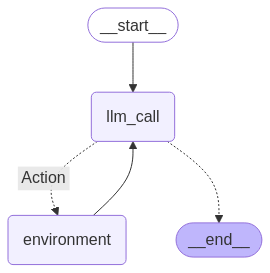

iterate number : 1


/home/jovyan/notebooks/Framework/base_tools.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query("""
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:81: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  if key in self.model_fields:
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:82: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields[key].default is not None


================================ Human Message =================================


        You are a recommendation engine trained to analyze customer profiles and suggest personalized marketing strategies.

        Here is the current customer's demographic and profile data. Use this to personalize your recommendations:
    
        |    |   AEON_ID |   AGE |   DAYS_FROM_LAST_SALARY_UPDATE |   CUST_AGE | HOME_PROVINCE   | WORK_PROVINCE   |   SEX |   MARITAL_CODE |   EDUCATION |   FAMILY_SIZE |   CHILDREN | CUSTOMER_LEVEL   | CUSTOMER_TYPE   |   HOUSE_CODE |   YEAR_THERE |   STAY_WITH |   EMPLOYMENT_CODE | BUSINESS_TYPE_DESC   | TYPE_OF_JOB_DESC   |   YEARS_OF_JOB |   SALARY |   E_STATEMENT_STATUS_FLAG | PERIOD   | LATEST_PROMOTION_CR   | LATEST_REWARD_TYPE              | LATEST_SHOPPING_DISCOUNT_CR   |
|---:|----------:|------:|-------------------------------:|-----------:|:----------------|:----------------|------:|---------------:|------------:|--------------:|-----------:|:--------

/home/jovyan/notebooks/Framework/base_tools.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query("""
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:81: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  if key in self.model_fields:
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:82: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields[key].default is not None


================================ Human Message =================================


        You are a recommendation engine trained to analyze customer profiles and suggest personalized marketing strategies.

        As context, here is the previously generated recommendation from your last prediction. You may reference it for background, but do not copy or overly rely on it. Instead, use it to better understand the evolution of the customer's behavior and preferences.

        Previous customer information:
        
        |    |   AEON_ID |   AGE |   DAYS_FROM_LAST_SALARY_UPDATE |   CUST_AGE | HOME_PROVINCE   | WORK_PROVINCE   |   SEX |   MARITAL_CODE |   EDUCATION |   FAMILY_SIZE |   CHILDREN | CUSTOMER_LEVEL   | CUSTOMER_TYPE   |   HOUSE_CODE |   YEAR_THERE |   STAY_WITH |   EMPLOYMENT_CODE | BUSINESS_TYPE_DESC   | TYPE_OF_JOB_DESC   |   YEARS_OF_JOB |   SALARY |   E_STATEMENT_STATUS_FLAG | PERIOD   | LATEST_PROMOTION_CR   | LATEST_REWARD_TYPE              | LATEST_SHOPPING_DISCOUN

/home/jovyan/notebooks/Framework/base_tools.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query("""
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:81: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  if key in self.model_fields:
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:82: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields[key].default is not None
/home/jovyan/notebooks/Framework/base_tools.py:114: UserWarning: pandas only suppor

================================ Human Message =================================


        You are a recommendation engine trained to analyze customer profiles and suggest personalized marketing strategies.

        As context, here is the previously generated recommendation from your last prediction. You may reference it for background, but do not copy or overly rely on it. Instead, use it to better understand the evolution of the customer's behavior and preferences.

        Previous customer information:
        
        |    |   AEON_ID |   AGE |   DAYS_FROM_LAST_SALARY_UPDATE |   CUST_AGE | HOME_PROVINCE   | WORK_PROVINCE   |   SEX |   MARITAL_CODE |   EDUCATION |   FAMILY_SIZE |   CHILDREN | CUSTOMER_LEVEL   | CUSTOMER_TYPE   |   HOUSE_CODE |   YEAR_THERE |   STAY_WITH |   EMPLOYMENT_CODE | BUSINESS_TYPE_DESC                         | TYPE_OF_JOB_DESC   |   YEARS_OF_JOB |   SALARY |   E_STATEMENT_STATUS_FLAG | PERIOD   | LATEST_PROMOTION_CR   | LATEST_REWARD_TYPE              | L

/opt/conda/lib/python3.11/site-packages/ollama/_types.py:81: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  if key in self.model_fields:
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:82: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields[key].default is not None
/home/jovyan/notebooks/Framework/base_tools.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query("""


================================ Human Message =================================


        You are a recommendation engine trained to analyze customer profiles and suggest personalized marketing strategies.

        As context, here is the previously generated recommendation from your last prediction. You may reference it for background, but do not copy or overly rely on it. Instead, use it to better understand the evolution of the customer's behavior and preferences.

        Previous customer information:
        
        |    |   AEON_ID |   AGE |   DAYS_FROM_LAST_SALARY_UPDATE |   CUST_AGE | HOME_PROVINCE   | WORK_PROVINCE   |   SEX |   MARITAL_CODE |   EDUCATION |   FAMILY_SIZE |   CHILDREN | CUSTOMER_LEVEL   | CUSTOMER_TYPE   |   HOUSE_CODE |   YEAR_THERE |   STAY_WITH |   EMPLOYMENT_CODE | BUSINESS_TYPE_DESC                         | TYPE_OF_JOB_DESC   |   YEARS_OF_JOB |   SALARY |   E_STATEMENT_STATUS_FLAG | PERIOD   | LATEST_PROMOTION_CR   | LATEST_REWARD_TYPE              | L

/opt/conda/lib/python3.11/site-packages/ollama/_types.py:81: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  if key in self.model_fields:
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:82: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields[key].default is not None


================================ Human Message =================================


        You are a recommendation engine trained to analyze customer profiles and suggest personalized marketing strategies.

        As context, here is the previously generated recommendation from your last prediction. You may reference it for background, but do not copy or overly rely on it. Instead, use it to better understand the evolution of the customer's behavior and preferences.

        Previous customer information:
        
        |    |   AEON_ID |   AGE |   DAYS_FROM_LAST_SALARY_UPDATE |   CUST_AGE | HOME_PROVINCE   | WORK_PROVINCE   |   SEX |   MARITAL_CODE |   EDUCATION |   FAMILY_SIZE |   CHILDREN | CUSTOMER_LEVEL   | CUSTOMER_TYPE   |   HOUSE_CODE |   YEAR_THERE |   STAY_WITH |   EMPLOYMENT_CODE | BUSINESS_TYPE_DESC   | TYPE_OF_JOB_DESC   |   YEARS_OF_JOB |   SALARY |   E_STATEMENT_STATUS_FLAG | PERIOD   | LATEST_PROMOTION_CR   | LATEST_REWARD_TYPE      | LATEST_SHOPPING_DISCOUNT_CR   |

/home/jovyan/notebooks/Framework/base_tools.py:114: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query("""


================================ Human Message =================================


        You are a recommendation engine trained to analyze customer profiles and suggest personalized marketing strategies.

        As context, here is the previously generated recommendation from your last prediction. You may reference it for background, but do not copy or overly rely on it. Instead, use it to better understand the evolution of the customer's behavior and preferences.

        Previous customer information:
        
        |    |   AEON_ID |   AGE |   DAYS_FROM_LAST_SALARY_UPDATE |   CUST_AGE | HOME_PROVINCE   | WORK_PROVINCE   |   SEX |   MARITAL_CODE |   EDUCATION |   FAMILY_SIZE |   CHILDREN | CUSTOMER_LEVEL   | CUSTOMER_TYPE   |   HOUSE_CODE |   YEAR_THERE |   STAY_WITH |   EMPLOYMENT_CODE | BUSINESS_TYPE_DESC                         | TYPE_OF_JOB_DESC   |   YEARS_OF_JOB |   SALARY |   E_STATEMENT_STATUS_FLAG | PERIOD   | LATEST_PROMOTION_CR   | LATEST_REWARD_TYPE              | L

/opt/conda/lib/python3.11/site-packages/ollama/_types.py:81: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  if key in self.model_fields:
/opt/conda/lib/python3.11/site-packages/ollama/_types.py:82: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields[key].default is not None


In [7]:
predicted_result = []
previous_user_info = []
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

for iterate in range(int(len(user_demographic)/4)):
    print(f"iterate number : {iterate+1}")
    if iterate == 0:
        user_info = user_demographic.iloc[iterate*4:(iterate*4)+4, ::].to_markdown()
    
        instruction = f"""
        You are a recommendation engine trained to analyze customer profiles and suggest personalized marketing strategies.

        Here is the current customer's demographic and profile data. Use this to personalize your recommendations:
    
        {user_info}

        Using RFM segmentation (recency, frequency, monetary) based on OVERALL_PERMONTH and OVERALL_PERTXN tables,  combined with demographic filters from the DEMOGRAPHIC table, and category spending insights from MERCHANT_GROUP_TRANSPORTATION, recommend the next best promotion_cr, reward_type, and shopping_discount_cr for this customer.

        Based on the data and your analysis, answer the following question:
    
        **What is the next suggestion for `promotion_cr`, `reward_type`, and `shopping_discount_cr` for this customer?**
    
        Respond in this format:
        - **promotion_cr**: [Your recommendation] - [Justification]
        - **reward_type**: [Your recommendation] - [Justification]
        - **shopping_discount_cr**: [Your recommendation] - [Justification]

        """

        
        messages = [HumanMessage(content= instruction)]
        
        messages = agent.invoke({"messages": messages})
        for m in messages["messages"]:                                                                              
            m.pretty_print()
            
        print(f"prediction result from iterate {iterate + 1}: {messages['messages'][-1]}")
        previous_user_info.append(user_info)  
        predicted_result.append(messages["messages"][-1])  

    else:
        user_info = user_demographic.iloc[iterate*4:(iterate*4)+4, ::].to_markdown()
    
        last_suggest_prompt = f"""
        You are a recommendation engine trained to analyze customer profiles and suggest personalized marketing strategies.

        As context, here is the previously generated recommendation from your last prediction. You may reference it for background, but do not copy or overly rely on it. Instead, use it to better understand the evolution of the customer's behavior and preferences.

        Previous customer information:
        
        {previous_user_info[iterate -1]}
        
        Previous customer prediction:
        
        {predicted_result[iterate -1]}
        """
        
        instruction = f"""
        Here is the current customer's demographic and profile data. Use this to personalize your recommendations:
    
        {user_info}

        Using RFM segmentation (recency, frequency, monetary) based on OVERALL_PERMONTH and OVERALL_PERTXN tables,  combined with demographic filters from the DEMOGRAPHIC table, and category spending insights from MERCHANT_GROUP_TRANSPORTATION, recommend the next best promotion_cr, reward_type, and shopping_discount_cr for this customer.
    
        Based on the data and your analysis, answer the following question:
    
        **What is the next suggestion for `promotion_cr`, `reward_type`, and `shopping_discount_cr` for this customer?**
    
        Respond in this format:
        - **promotion_cr**: [Your recommendation] - [Justification]
        - **reward_type**: [Your recommendation] - [Justification]
        - **shopping_discount_cr**: [Your recommendation] - [Justification]        
        """

        
        messages = [HumanMessage(content= last_suggest_prompt + instruction)]
        
        messages = agent.invoke({"messages": messages})
        for m in messages["messages"]:                                                                              
            m.pretty_print()
        
        print(f"prediction result from iterate {iterate + 1}: {messages['messages'][-1]}")
        previous_user_info.append(user_info)  
        predicted_result.append(messages["messages"][-1])  
    

In [8]:
for _ in predicted_result:
    print(_.pretty_print())

================================== Ai Message ==================================

To provide personalized recommendations for the next best `promotion_cr`, `reward_type`, and `shopping_discount_cr` for this customer, we need to analyze their demographic data and spending patterns. Let's break down the analysis step-by-step:

1. **Demographic Analysis**:
   - The customer is 48 years old.
   - They are employed in a private company.
   - Their marital status is married (code 2).
   - They have no children.

2. **Spending Patterns and Promotions**:
   - The latest promotion type was "Cash back (Your Cash)" with `promotion_cr` of 'MB'.
   - The latest reward type was also "Cash back (Your Cash)".
   - There is no recent shopping discount (`shopping_discount_cr`).

3. **Recommendations**:
   - Given the customer's employment in a private company and their age, they might benefit from more frequent promotions that encourage spending.
   - Since there has been no recent shopping discount, it